# Welcome to the Multi Object or Multi Leaf Tutorial
Made by: Katie Murphy
Updated: May 16, 2023

Updated March, 2025 by Juan Pablo 

First, import the necessary Python packages. 

In [47]:
%matplotlib inline
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

Next, initialize your workflow inputs. It's possible to just directly read a sample image, but this step sets up a workflow to be used later in batch processing/running in parallel. Remember, always keep your raw images separate from your newly processed images! 

In [8]:
# Input/output options
args = WorkflowInputs(
    images=["./imgs/O_HLP_1_P_LEAF_2022-12-07_09_32_15.jpg"],
    names="image",
    result="example_results_oneimage_file.json",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [9]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

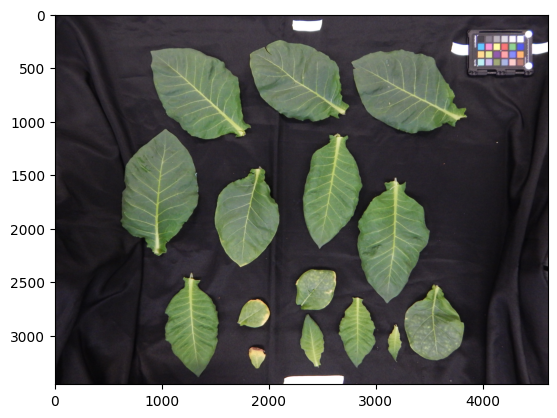

In [10]:
# Read in your image, which is based on the path you put above

img, path, filename = pcv.readimage(filename=args.image)


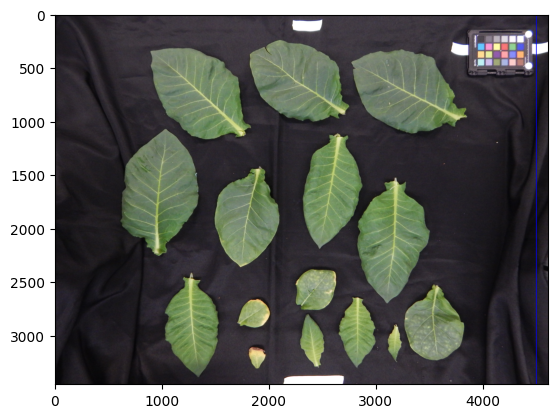

In [11]:
# Crop image if necessary. This is optional. 
crop_img = pcv.crop(img=img, x=0, y=0, h=3500, w=4500)

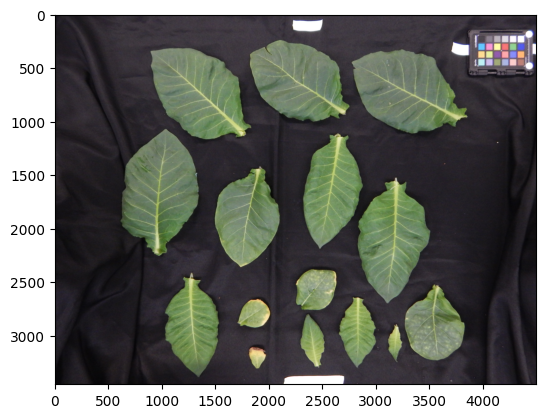

In [12]:
# If your image is not straight, rotate it. Here our image is straight becasue our camera was 
# on a flat surface, so we will rotate 0 degrees (unchanged). 

rotate_img = pcv.transform.rotate(crop_img, 0, False)

In [13]:
#First, find the color card. You won't see any output of this function. 

dataframe1, start1, space1 = pcv.transform.find_color_card(rgb_img=rotate_img, background='light')

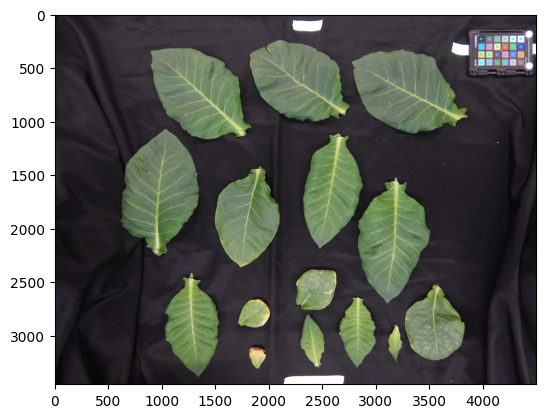

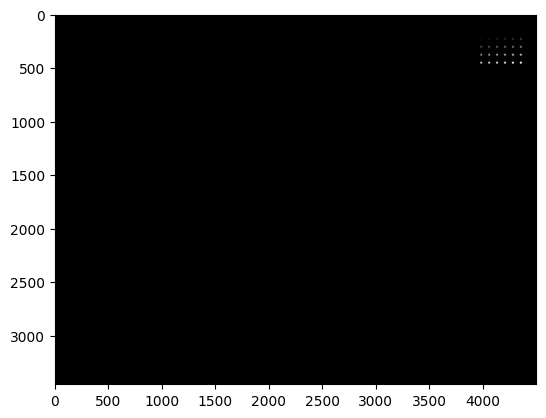

In [14]:
#Make a color card mask for your image. You should see that the color card has little circles on it, nicely inside the color squares.
#If the color card can't be found, you may need to set the start coordinate and spacing manually. 

card_mask = pcv.transform.create_color_card_mask(rotate_img, radius=10, start_coord=start1, 
                                                   spacing=space1, nrows=4, ncols=6)

In [15]:
# Make a color card matrix 

headers, card_matrix = pcv.transform.get_color_matrix(rgb_img=rotate_img, mask=card_mask)

In [16]:
# Define the standard color card matrix, we know what the colors of those chips should be in an "ideal" image, 
# so we will correct to those values as the TARGET c
# Look at where your white chip is in the image to determine which position your card is in (pos)

#pos     = reference value indicating orientation of the color card. The reference
       #         is based on the position of the white chip:
        #        pos = 0: bottom-left corner
        #        pos = 1: bottom-right corner
        #        pos = 2: top-right corner
        #        pos = 3: top-left corner

std_color_matrix = pcv.transform.std_color_matrix (pos=2)

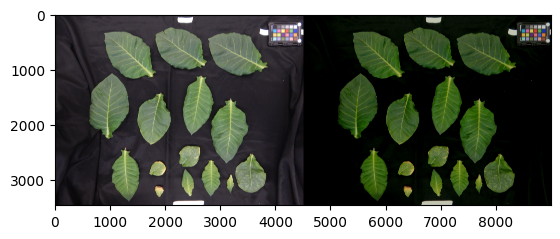

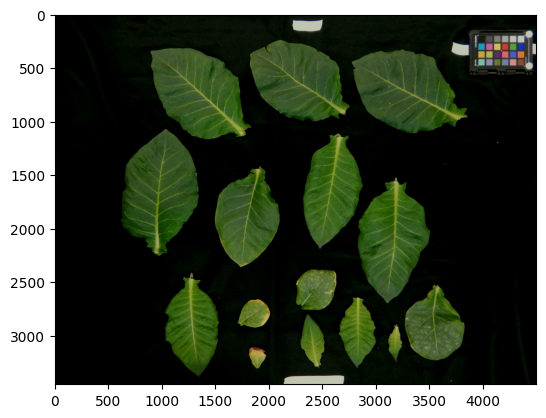

In [17]:
# Color correct your image to the standard values
# look at the image - does the color look good? 
# If it looks crazy, you probably don't have the card found well and need to go back and 
# define the start and spacing for the card

img_cc = pcv.transform.affine_color_correction(rgb_img=rotate_img, source_matrix=card_matrix, 
                                               target_matrix=std_color_matrix)
pcv.plot_image(img_cc)

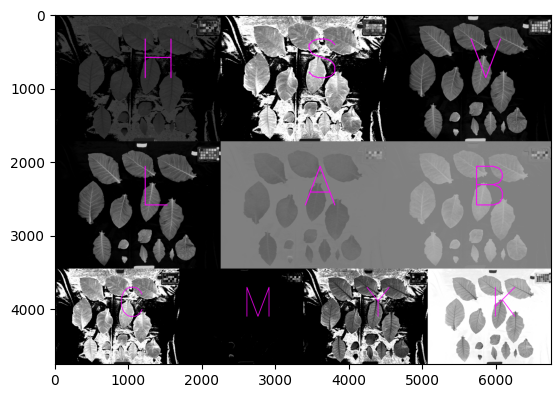

In [18]:
# Update params related to plotting so we can see better 
pcv.params.text_size=50
pcv.params.text_thickness=25


#Look at the colorspace - which of these looks the best for masking? 
# Which channel makes the plant look most distinct from the background?
colorspace_img = pcv.visualize.colorspaces(rgb_img=img_cc, original_img=False)

In [19]:
#If you want to save your color corrected image, do so here. Do NOT save over your raw image. 
# We are saving as a temporary image here becasue we want to use it for thresholding. 

pcv.print_image(img_cc, filename = "./color_corrected_img_temp.png")

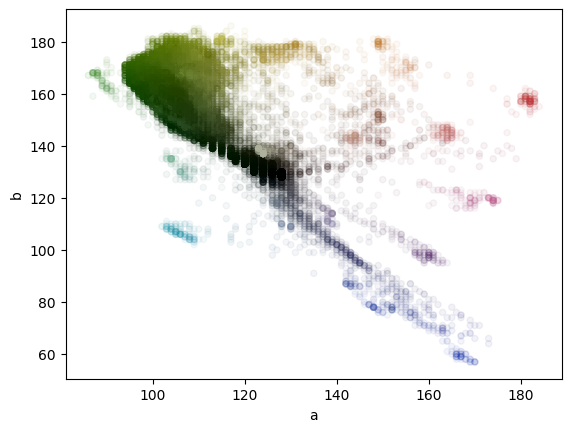

In [20]:
#Visualize all the colors to make decisions on how to threshold. I picked the two channels from the colorspace above that looked distinct

color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs=["./color_corrected_img_temp.png"], 
                                                 x_channel = "a", y_channel ="b" )



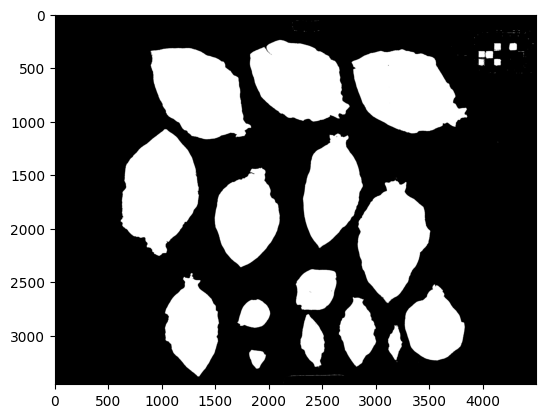

In [21]:
# Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else. 
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?

thresh1 = pcv.threshold.dual_channels(rgb_img = img_cc, x_channel = "a", y_channel = "b", 
                                      points = [(100,120),(130,160)], above=True)

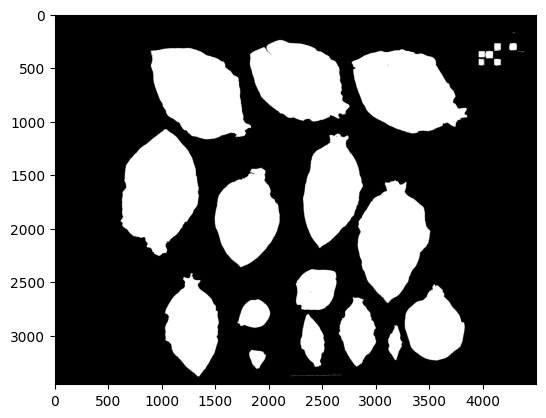

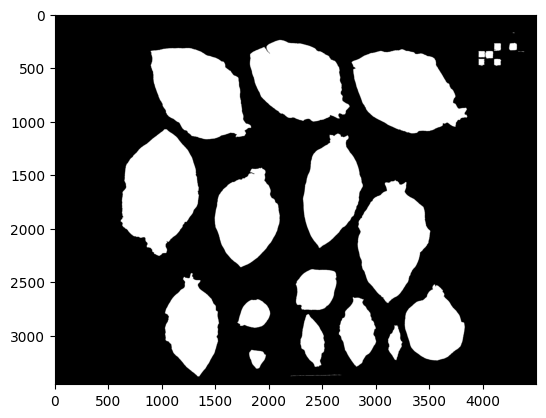

In [22]:
# Fill in small objects if below the "size" threshold
a_fill_image = pcv.fill(bin_img=thresh1, size=50)
# Flood fill any holes in the leaves (false negative pixels)
a_fill_image = pcv.fill_holes(a_fill_image)


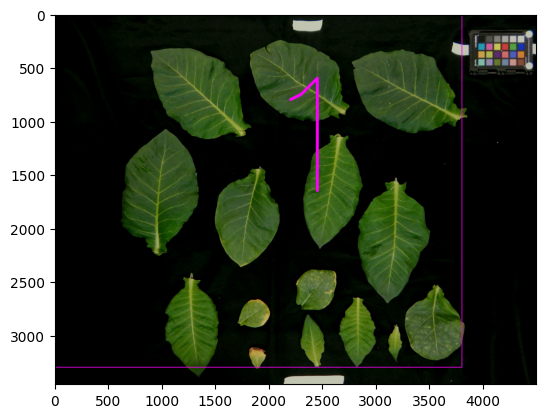

In [23]:
# Define the region of interest (ROI). 
# This should include  all of your leaves or all of your plants, but not you color card or other noise. 

roi1 = pcv.roi.rectangle(img=img_cc, x=0, y=0, h=3300, w=3800)



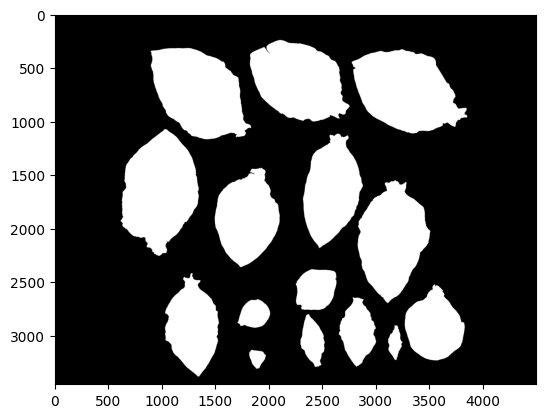

In [24]:
# Make a new filtered mask that only keeps the leaves in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf extends outside of your ROI it will still be selected. Switch to "cutto" if you have other plants that are getting selected on accident

# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=a_fill_image, roi=roi1, roi_type='partial')


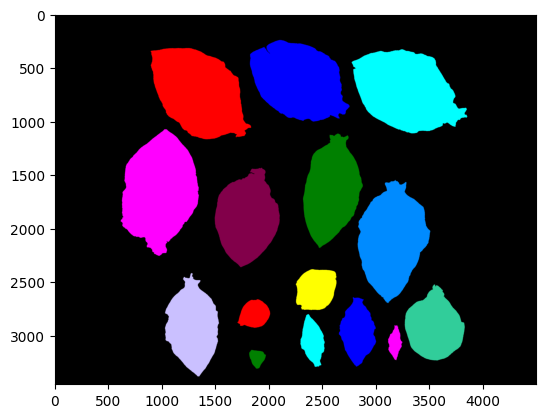

In [48]:
#Label the objects in your region of interest and number them
#Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask so that they are separate or it will treat them as a single object

#    mask            = the clean mask you made above after making your ROI

labeled_objects, n_obj = pcv.create_labels(mask=kept_mask)

# This example has one color per leaf, so this would be good enough to do per-replicate trait extraction. 

There are multiple ways to get your leaves. If you are finding this single, large ROI is not getting your plants individually, try another method.  Here, we will use the interactive tool to click on locations to make ROIs. This is a good method if you cannot get a clean ROI using single or multi. This method cannot be run in paralell, only in a jupyter notebook, because you cannot "interact" in paralell. 

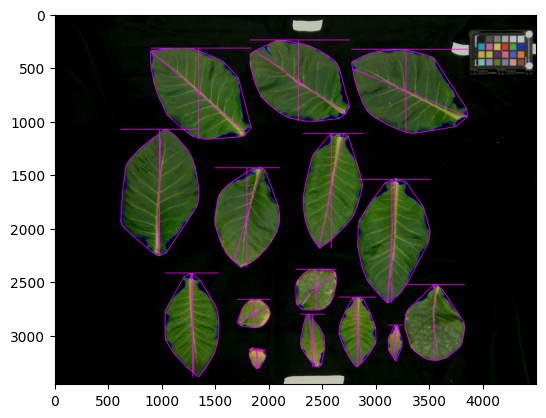

In [49]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=img_cc, labeled_mask=labeled_objects, n_labels=n_obj)


In [50]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)


color_histogram = pcv.analyze.color(rgb_img=img_cc, labeled_mask=labeled_objects, n_labels=n_obj, colorspaces='hsv')


alt.FacetChart(...)

In [51]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: pcv.analyze.bound_horizontal, pcv.analyze.bound_vertical, pcv.analyze.color, pcv.analyze.grayscale, pcv.analyze.size, 
# pcv.analyze.yii, pcv.report_size_marker_area, pcv.watershed_segmentation. If no functions have been run, it will print an empty text file 

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result)


Other method for selection!

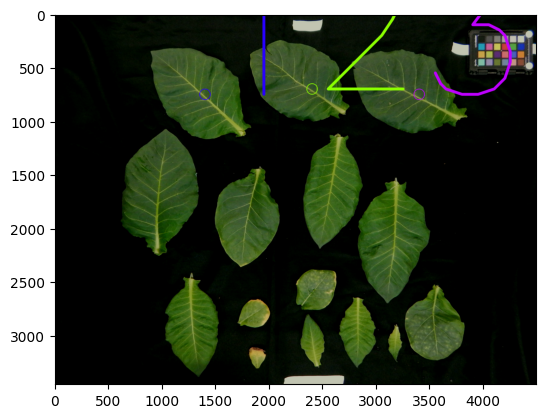

In [52]:
# collect points for center of ROIs by clicking on each leaf. 
#marker = pcv.Points(img_cc, figsize=(8,8))
marker_points= [(1400,750),(2400,700),(3400,750)]

# Create ROIs based on the selected points
# Your ROIs will show up as blue circles here. 
#roi2 = pcv.roi.multi(img=img_cc, coord=marker.points, radius=50)
roi2 = pcv.roi.multi(img=img_cc, coord=marker_points, radius=50)

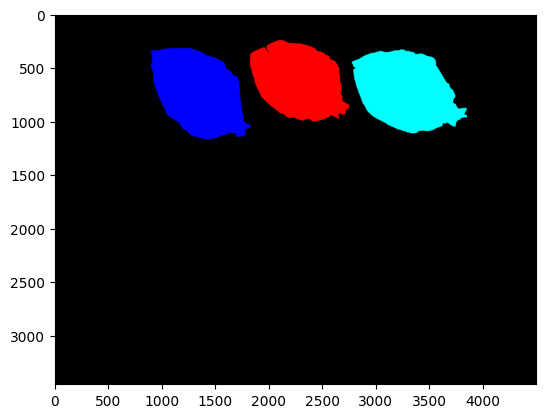

In [53]:
# Label the objects in your region of interest and number them
# Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask 
# so that they are separate or it will treat them as a single object


labeled_objects2, n_obj2 = pcv.create_labels(mask=a_fill_image, rois=roi2, roi_type="partial")